#### 1. Load and Inspect the Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/Insurance.csv")

# Preview structure
print("Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
df.head()

Shape: (2082, 23)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Customer ID                      2082 non-null   int64 
 1   Age                              2082 non-null   int64 
 2   Gender                           2082 non-null   object
 3   Marital Status                   2082 non-null   object
 4   Occupation                       2082 non-null   object
 5   Income Level                     2082 non-null   int64 
 6   Education Level                  2082 non-null   object
 7   Geographic Information           2082 non-null   object
 8   Location                         2082 non-null   int64 
 9   Purchase History                 2082 non-null   object
 10  Policy Start Date                2082 non-null   object
 11  Policy Renewal Date              2082 non-null   object
 12  Cl

,Customer ID,Age,Gender,Marital Status,Occupation,Income Level,Education Level,Geographic Information,Location,Purchase History,...,Coverage Amount,Premium Amount,Deductible,Policy Type,Preferred Communication Channel,Preferred Contact Time,Risk Profile,Credit Score,Driving Record,Life Events
0,15043,48,Female,Single,Engineer,72654,Associate Degree,Karnataka,75177,1/24/2020,...,387399,1713,1413,Group,Email,Morning,0,649,Major Violations,Divorce
1,88777,50,Male,Divorced,Manager,93448,Master's Degree,Karnataka,56707,1/10/2023,...,621476,2416,1383,Group,Email,Evening,2,540,Clean,Divorce
2,62911,53,Male,Widowed,Doctor,92558,Doctorate,Arunachal Pradesh,60225,12/12/2021,...,775683,3765,1165,Group,In-Person Meeting,Afternoon,3,573,DUI,Childbirth
3,38955,38,Male,Widowed,Salesperson,78536,High School Diploma,Andhra Pradesh,34707,2/1/2023,...,580924,3204,1345,Business,Email,Weekends,2,550,DUI,Marriage
4,3935,42,Male,Married,Salesperson,90220,High School Diploma,Puducherry,14225,2/18/2021,...,711361,2941,1111,Group,In-Person Meeting,Morning,3,568,Clean,Childbirth


#### 2. Premium Drivers – Explore the Target

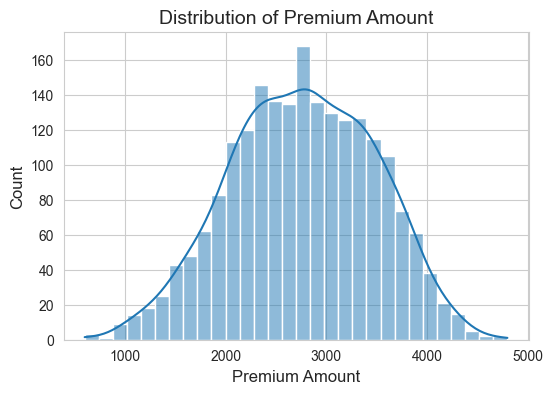

In [21]:
# Histogram of Premium Amount
plt.figure(figsize=(6,4))
sns.histplot(df['Premium Amount'], bins=30, kde=True)
plt.title("Distribution of Premium Amount")
plt.savefig("charts/premium_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

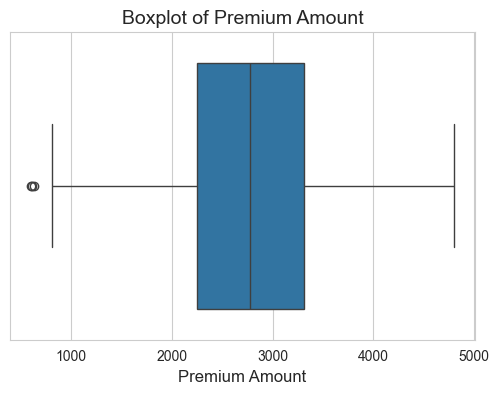

In [22]:
# Boxplot of Premium Amount
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Premium Amount'])
plt.title("Boxplot of Premium Amount")
plt.savefig("charts/premium_boxplot.png", dpi=300, bbox_inches='tight')    
plt.show()

The premium distribution is roughly bell-shaped, centered around **~3,000**, with most policies between **2,000 and 3,500**.
A few **low-premium outliers** fall below about 1,000, and only a small tail extends above 4,500.
This indicates a fairly tight pricing range with a small set of minimal-coverage customers and a modest high-end segment for potential upsell.


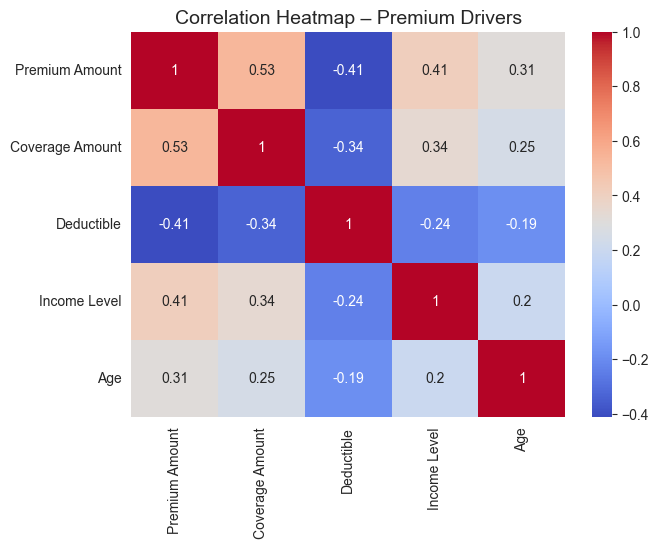

In [28]:
# Correlations with Numeric Drivers
num_cols = ['Premium Amount','Coverage Amount','Deductible','Income Level','Age']
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap – Premium Drivers")
plt.savefig("charts/Correlations.png", dpi=300, bbox_inches='tight')  
plt.show()

Premium amount rises strongly with **coverage** and **income**, while it drops as **deductible** increases.
Age shows only a mild positive link, suggesting price is driven more by policy size and customer income than by age.

#### 3. Risk vs Revenue Segments – Clustering

,Premium Amount,Coverage Amount,Deductible,Age
Segment,,,,
0,2930.0,562287.0,1186.0,42.0
1,2099.0,401575.0,1367.0,43.0
2,3305.0,590010.0,1131.0,50.0


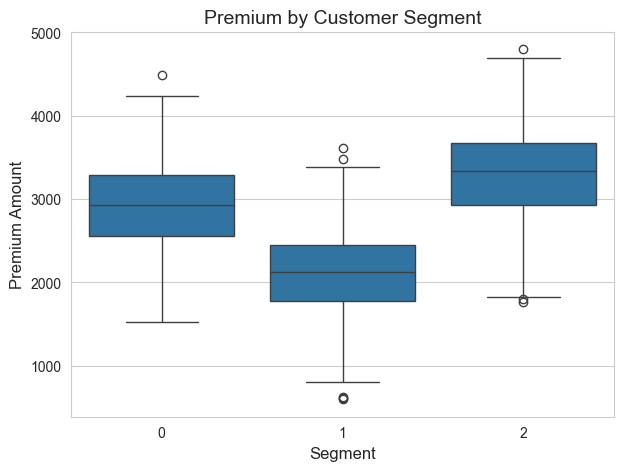

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = df[['Premium Amount','Coverage Amount','Deductible','Age']]
scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Segment'] = kmeans.fit_predict(scaled)
# Average values for key drivers in each segment
segment_profile = (
    df.groupby('Segment')[['Premium Amount',
                           'Coverage Amount',
                           'Deductible',
                           'Age']]
      .mean()
      .round(0)
)
display(segment_profile)


sns.boxplot(x='Segment', y='Premium Amount', data=df)
plt.title("Premium by Customer Segment")
plt.savefig("charts/Segment.png", dpi=300, bbox_inches='tight')  
plt.show()

- Segment 2 represents high-revenue, higher-risk customers with the largest premiums and coverage but the smallest deductibles.
- Segment 1 are budget customers with the lowest premiums and highest deductibles.
- Segment 0 sits in between, offering balanced revenue and risk.

#### 4. Retention & Upsell Indicators

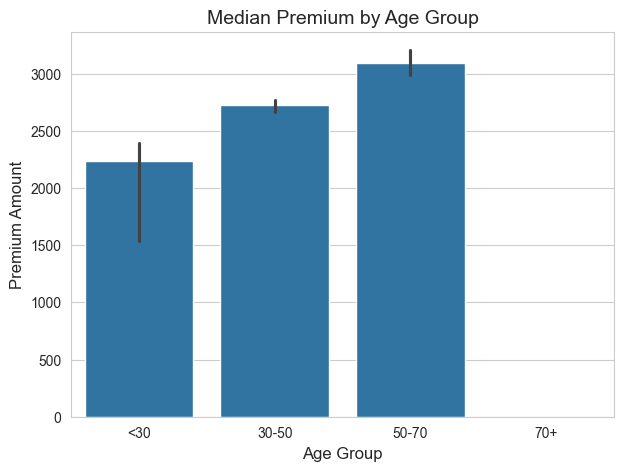

In [33]:
# Cross-tab with communication channel
pd.crosstab(df['Segment'], df['Preferred Communication Channel'],
            normalize='index')*100

# Age group or occupation if present
if 'Age' in df.columns:
    age_bins = [0,30,50,70,100]
    df['Age Group'] = pd.cut(df['Age'], bins=age_bins,
                             labels=['<30','30-50','50-70','70+'])
    sns.barplot(x='Age Group', y='Premium Amount', data=df, estimator=np.median)
    plt.title("Median Premium by Age Group")
    plt.show()


The black lines represent a bootstrap confidence interval (by default 95%) for the median premium in each age group.
They give a quick visual cue of how stable the median estimate is:
Short bars → the median is precise (low variability).
Tall bars → more spread in the data or fewer samples, so the median is less certain.

**Insight**: Premiums tend to increase steadily with age, peaking in the 50–70 group.
Older customers therefore represent a higher-value segment for targeted retention or upsell campaigns.

#### Summary

- The analysis shows that coverage amount and deductible are the strongest premium drivers, with income and age having smaller effects.
- Clustering customers reveals a high-revenue segment (high coverage, low deductible), a balanced mid-range group, and a low-value basic group, helping target pricing and marketing.
- Premiums also rise steadily with age, highlighting middle-aged and older customers as key opportunities for retention and upsell.